In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from keras.layers import Input,Embedding,Flatten,Dense,Dropout,merge
from keras.models import Model
from keras.losses import mean_absolute_error,mae,MSE
from keras.utils import to_categorical

Using TensorFlow backend.


### Loadind dataset

In [3]:
df_rating=pd.read_csv('../../All_datasets/movieLens/ml-1m/ratings.dat',sep='::',names=['user_id','movie_id','rating','timestamp'])
df_rating.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df_rating.shape

(1000209, 4)

In [5]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


In [6]:
df_movie=pd.read_csv('../../All_datasets/movieLens/ml-1m/movies.dat',sep='::',names=['movie_id','title','genres'])
df_movie.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_movie.shape

(3883, 3)

In [8]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [9]:
df_user=pd.read_csv('../../All_datasets/movieLens/ml-1m/users.dat',sep='::',names=['user_id','gender','age','Occupation','pin_code'])
df_user.head()

,user_id,gender,age,Occupation,pin_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [10]:
df_user.shape

(6040, 5)

In [11]:
df_user.user_id.nunique()

6040

In [12]:
df_movie.movie_id.nunique()

3883

In [13]:
df_rating.movie_id.nunique()

3706

In [14]:
df_rating.user_id.nunique()

6040

In [20]:
num_users = df_user.user_id.unique()
user_map = {i:val for i,val in enumerate(num_users)}
inverse_user_map = {val:i for i,val in enumerate(num_users)}

In [24]:
print ("We have %d users"%num_users.shape[0])

We have 6040 users


In [26]:
num_movie = df_movie.movie_id.unique()
movie_map = {i:val for i,val in enumerate(num_movie)}
inverse_movie_map = {val:i for i,val in enumerate(num_movie)}
print ("We have %d movie"%num_movie.shape[0])

We have 3883 movie


In [30]:
print(num_users,num_movie)

[   1    2    3 ... 6038 6039 6040] [   1    2    3 ... 3950 3951 3952]


In [59]:
df_rating["user_id"] = df_rating["user_id"].map(inverse_user_map)
df_rating["movie_id"] = df_rating["movie_id"].map(inverse_movie_map)
df_rating.tail()

,user_id,movie_id,rating,timestamp
1000204,6039,1075,1,956716541
1000205,6039,1078,5,956704887
1000206,6039,558,5,956704746
1000207,6039,1080,4,956715648
1000208,6039,1081,4,956715569


### spliting

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
df_train,df_test=train_test_split(df_rating,test_size=0.2)

In [63]:
df_train.shape

(800167, 4)

In [64]:
df_test.shape

(200042, 4)

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800167 entries, 817557 to 52131
Data columns (total 4 columns):
user_id      800167 non-null int64
movie_id     800167 non-null int64
rating       800167 non-null int64
timestamp    800167 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


In [66]:
df_train.user_id.values

array([4906, 4949,  481, ...,  999, 4379,  342], dtype=int64)

In [67]:
df_train.movie_id.values

array([3278, 1850, 2502, ..., 2297,  290, 2547], dtype=int64)

### keras Model

In [68]:
user_id_input=Input(shape=[1],name='user_input')
user_embedding_size=3
user_embedding=Embedding(num_users.shape[0],user_embedding_size,name='user-embedding')(user_id_input)
user_vec=Flatten(name='user-flatten')(user_embedding)

In [69]:
movie_id_input=Input(shape=[1],name='movie_input')
movie_embedding_size=3
movie_embedding=Embedding(num_movie.shape[0],movie_embedding_size,name='movie-embedding')(movie_id_input)
movie_vec=Flatten(name='movie-flatten')(movie_embedding)

In [70]:
concat=merge([user_vec,movie_vec],mode='concat',name='concat1')

In [71]:
dr1=Dropout(0.2)(concat)
d1=Dense(256,activation='relu')(dr1)
dr2=Dropout(0.2)(d1)
d2=Dense(128,activation='relu')(dr2)
dr3=Dropout(0.2)(d2)
d3=Dense(64,activation='relu')(dr3)
dr4=Dropout(0.2)(d3)
result=Dense(1,activation='relu')(dr4)

In [72]:
model=Model([user_id_input,movie_id_input],result)

In [146]:
model.compile(optimizer='adam',loss="mae",metrics=['accuracy']) #mean_squared_error

In [147]:
history = model.fit([df_train['user_id'].values, df_train['movie_id'].values],df_train['rating'].values,
                    epochs=10, verbose=1,batch_size=64,validation_split=0.1)

Train on 720150 samples, validate on 80017 samples
Epoch 1/10
720150/720150 [==============================] - 29s 40us/step - loss: 0.6887 - acc: 0.4357 - val_loss: 0.6912 - val_acc: 0.4164
Epoch 2/10
720150/720150 [==============================] - 29s 40us/step - loss: 0.6819 - acc: 0.4418 - val_loss: 0.6895 - val_acc: 0.4191
Epoch 3/10
720150/720150 [==============================] - 28s 39us/step - loss: 0.6780 - acc: 0.4464 - val_loss: 0.6909 - val_acc: 0.4255
Epoch 4/10
720150/720150 [==============================] - 29s 40us/step - loss: 0.6753 - acc: 0.4508 - val_loss: 0.6859 - val_acc: 0.4282
Epoch 5/10
720150/720150 [==============================] - 28s 40us/step - loss: 0.6739 - acc: 0.4516 - val_loss: 0.6897 - val_acc: 0.4235
Epoch 6/10
720150/720150 [==============================] - 28s 39us/step - loss: 0.6728 - acc: 0.4517 - val_loss: 0.6815 - val_acc: 0.4293
Epoch 7/10
720150/720150 [==============================] - 28s 39us/step - loss: 0.6721 - acc: 0.4528 - val_

Text(0,0.5,'Train Error')

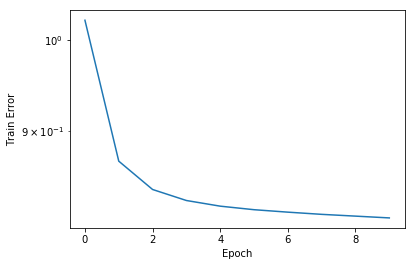

In [75]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [94]:
y_hat=model.predict([df_test['user_id'], df_test['movie_id']])
y_hat_rounoff = np.round(model.predict([df_test['user_id'], df_test['movie_id']]))

In [95]:
df_result=pd.DataFrame({'y_true':df_test.rating,'y_pred':y_hat[:,0],'round_off':y_hat_rounoff[:,0]})
df_result

,y_true,y_pred,round_off
869406,3,3.460225,3.0
820843,3,3.330491,3.0
848436,5,3.316055,3.0
947321,5,3.171963,3.0
296294,3,4.453205,4.0
879827,5,4.368780,4.0
882962,4,3.688288,4.0
442782,4,3.962634,4.0
148234,4,3.263155,3.0
936062,4,3.229198,3.0


In [96]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_result.y_true, df_result.y_pred)

0.7245564954874463

In [97]:
mean_absolute_error(df_result.y_true, df_result.round_off)

0.689720158766659

In [102]:
df_rating.head()

,user_id,movie_id,rating,timestamp
0,0,1176,5,978300760
1,0,655,3,978302109
2,0,902,3,978301968
3,0,3339,4,978300275
4,0,2286,5,978824291


In [140]:
pred_user_id=np.array([inverse_user_map[59]])
pred_movie_id=np.array([inverse_movie_map[525]])

In [141]:
model.predict([pred_user_id,pred_movie_id])

array([[3.0624118]], dtype=float32)